In [1]:
# Import libraries

from cil.framework import  AcquisitionGeometry, BlockDataContainer

from cil.optimisation.functions import L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG, SPDHG, SIRT
from cil.plugins.astra.operators import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise
from cil.processors import Slicer
from cil.plugins.astra.utilities import convert_geometry_to_astra
import cupy
import matplotlib.pyplot as plt
import astra
import numpy as np
import cupy as cp
import dask
import dask.array as da

# Create CIL Image and Acquisition geometries

In [2]:
# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel3D()\
                        .set_angles(angles)\
                        .set_panel([detectors,detectors], [0.1,0.1])\
                        .set_labels([ 'vertical', 'angle','horizontal'])
# Get image geometry
ig = ag.get_ImageGeometry()

In [3]:
iterations = 10

# Create Phantom and Acquisition data

In [4]:
phantom = TomoPhantom.get_ImageData(12, ig)

In [5]:
A_cil = ProjectionOperator(ig, ag)
data_cil = A_cil.direct(phantom)

# Run SIRT using CIL

In [6]:
x_cil = ig.allocate()

sirt_cil = SIRT(initial = x_cil, operator = A_cil, data=data_cil, 
        max_iteration = iterations, update_objective_interval=10)

SIRT setting up
SIRT configured


In [7]:
%%time
sirt_cil.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0         10         0.000          5.59701e+07
       10         10         0.428          2.58416e+06
-------------------------------------------------------
       10         10         0.428          2.58416e+06
Stop criterion has been reached.

CPU times: user 2.34 s, sys: 1.95 s, total: 4.29 s
Wall time: 4.29 s


# SIRT ASTRA

In [8]:
ig_astra, ag_astra = convert_geometry_to_astra(ig, ag)

proj_id, proj_data = astra.create_sino3d_gpu(phantom.array, ag_astra, ig_astra)
rec_id = astra.data3d.create('-vol', ig_astra)

cfg = astra.astra_dict('SIRT3D_CUDA')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = proj_id

alg_id = astra.algorithm.create(cfg)

num_iterations = iterations

In [9]:
%%time
astra.algorithm.run(alg_id, num_iterations)

CPU times: user 504 ms, sys: 120 ms, total: 624 ms
Wall time: 642 ms


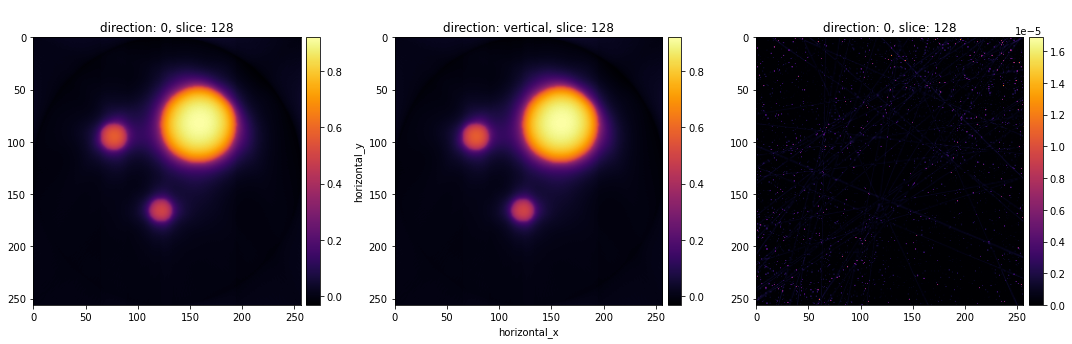

In [10]:
sirt_astra = astra.data3d.get(rec_id)
show2D([sirt_astra, sirt_cil.solution, np.abs(sirt_cil.solution.array-sirt_astra)], 
       cmap="inferno", 
       origin="upper", 
       num_cols=3)

In [11]:
from cil.optimisation.operators import LinearOperator
import numpy as np
from cil.plugins.astra.operators import ProjectionOperator
from functools import reduce
import operator

# There is an issue with GPULink and cuda libraries, e.g., pygpu & cupy
# https://github.com/astra-toolbox/astra-toolbox/issues/280

def correct_allocate(shape):
    tmp_cupy = cp.empty((shape[0], shape[1], int(np.ceil(shape[2]/32)*32)), dtype=cp.float32)
    arr_cupy = tmp_cupy[:, :, :shape[2]]
    return arr_cupy

class ProjectionOperator_cupy(LinearOperator):
        
    def __init__(self, image_geometry, acquisition_geometry):
        
        # cil geometries
        self.ig_cil = image_geometry
        self.ag_cil = acquisition_geometry
        
        # astra geometries
        self.ig_astra, self.ag_astra = convert_geometry_to_astra(self.ig_cil, self.ag_cil)
        
        # CIL ProjectionOperator no cupy
        self.proj_op_cil = ProjectionOperator(self.ig_cil, self.ag_cil)
                            
    def direct(self, x, out=None):
        
                
        # empty cupy space in image space
        tmp_x = correct_allocate(self.ig_cil.shape)

        # fill it with corrected allocation of x         
        tmp_x[:], x = x, tmp_x

                
        if isinstance(x, np.ndarray):
            
            return self.proj_op_cil.direct(x, out=out)
        
        elif isinstance(x, cp.core.core.ndarray):
                        
            link_gpu_at_x = astra.data3d.GPULink(x.data.ptr, *x.shape[::-1], x.strides[-2])
            vol_id = astra.data3d.link('-vol', self.ig_astra, link_gpu_at_x)
            
            out = correct_allocate(self.ag_cil.shape)
            link_gpu_at_out = astra.data3d.GPULink(out.data.ptr, *out.shape[::-1], out.strides[-2])
            sino_id = astra.data3d.link('-sino', self.ag_astra, link_gpu_at_out)
            
            cfg = astra.creators.astra_dict('FP3D_CUDA')
            cfg['ProjectionDataId'] = sino_id
            cfg['VolumeDataId'] = vol_id
            fp_id = astra.algorithm.create(cfg)
            astra.algorithm.run(fp_id)   
    
            astra.algorithm.delete(fp_id)
            astra.data3d.delete([vol_id, sino_id])              
            
            return out
        
    def adjoint(self, x, out=None):
                        
        # empty cupy space in sinogram space
        tmp_x = correct_allocate(self.ag_cil.shape)
        
        # fill it with corrected allocation of x         
        tmp_x[:], x = x, tmp_x        
                        
        if isinstance(x, np.ndarray):
            
            return self.proj_op_cil.adjoint(x, out=out) 
        
        elif isinstance(x, cp.core.core.ndarray):
            
            link_gpu_at_x = astra.data3d.GPULink(x.data.ptr, *x.shape[::-1], x.strides[-2])
            sino_id = astra.data3d.link('-sino', self.ag_astra, link_gpu_at_x) 
    
            out = correct_allocate(self.ig_cil.shape)
               
            link_gpu_at_out = astra.data3d.GPULink(out.data.ptr, *out.shape[::-1], out.strides[-2])

            vol_id = astra.data3d.link('-vol',self.ig_astra, link_gpu_at_out)
            
            cfg = astra.creators.astra_dict('BP3D_CUDA')
            cfg['ProjectionDataId'] = sino_id
            cfg['ReconstructionDataId'] = vol_id
            bp_id = astra.algorithm.create(cfg)
            astra.algorithm.run(bp_id)       
            
            astra.algorithm.delete(bp_id)
            astra.data3d.delete([vol_id, sino_id]) 
                      
            return out

# SIRT cupy

In [12]:
A_cupy = ProjectionOperator_cupy(ig, ag)
M = 1./A_cupy.direct(cupy.ones(ig.shape))
D = 1./A_cupy.adjoint(cupy.ones(ag.shape))

In [13]:
# not necessary
from numpy import inf
M[M == cupy.inf] = 0.
D[D == cupy.inf] = 0.

In [14]:
x_cupy = cupy.zeros(ig.shape, dtype=cp.float32)

In [15]:
phantom_cupy = cupy.array(phantom.array, dtype=cp.float32)
data_cupy = A_cupy.direct(phantom_cupy)

In [16]:
%%time
for i in range(iterations):
    
    tmp = data_cupy - A_cupy.direct(x_cupy)
    tmp *= M
    tmp1 = A_cupy.adjoint(tmp)
    tmp1 *= D
    x_cupy += tmp1
    
#     x_cupy += cupy.multiply(D , A_cupy.adjoint(cupy.multiply(M , (data_cupy - A_cupy.direct(x_cupy)) )))
    

CPU times: user 329 ms, sys: 91.5 ms, total: 420 ms
Wall time: 430 ms


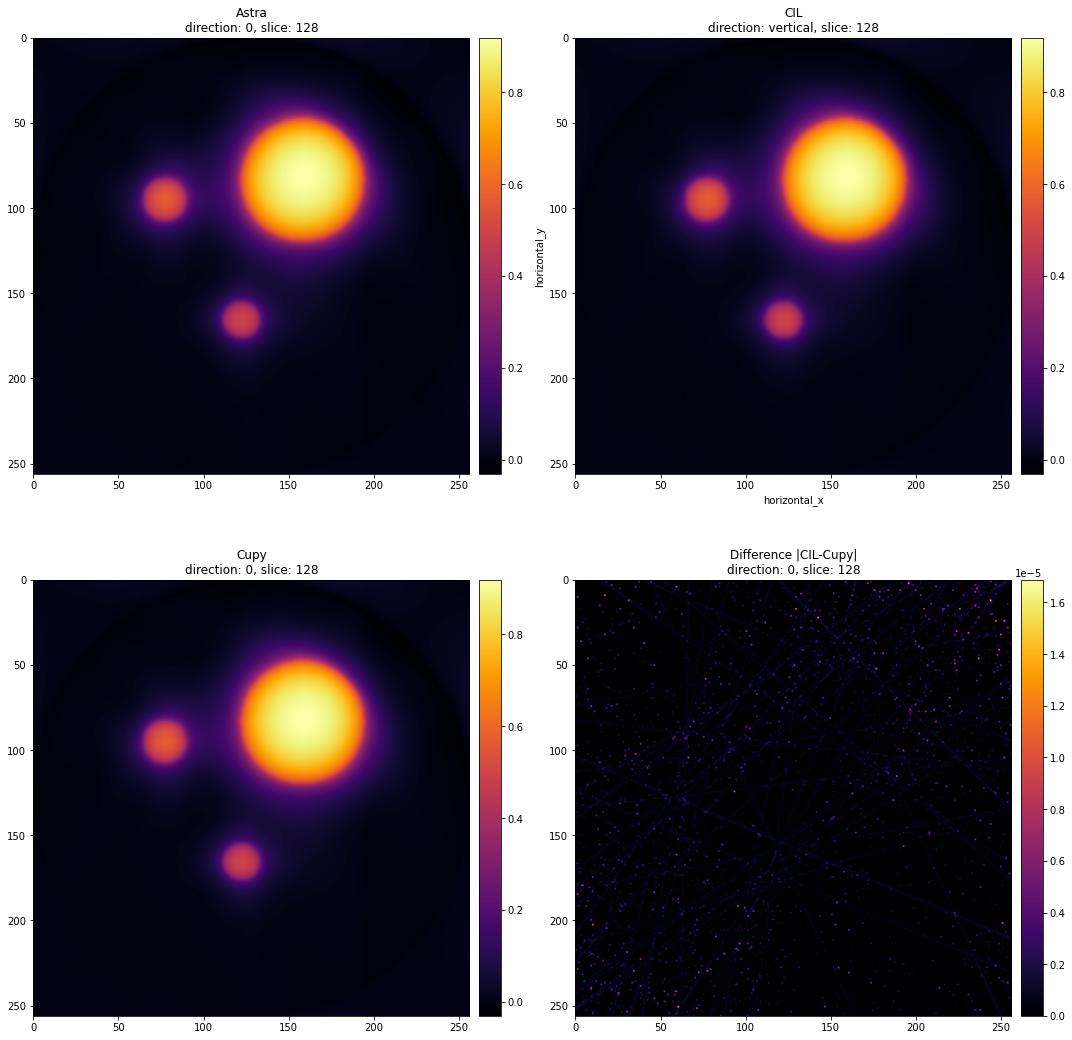

In [17]:
show2D([sirt_astra, 
        sirt_cil.solution, 
        cupy.asnumpy(x_cupy),
        np.abs(sirt_cil.solution.array-cupy.asnumpy(x_cupy))], 
       cmap="inferno", 
       origin="upper", 
       num_cols=2, title=['Astra','CIL','Cupy','Difference |CIL-Cupy|'])

### This was an example of connecting CuPy with Astra toolbox. To wrap it inside CIL and `DataContainers` we need to have a **cupy space** defined with all the algebra.